# ***Уравнения мелкой воды*** 
***Линейный одномерный случай***

\begin{cases}
    \frac{\partial u}{\partial t} = - g \frac{\partial h}{\partial x}\\
    \frac{\partial h}{\partial t} = - H \frac{\partial u}{\partial x}
\end{cases}

Разностсная схема: МРК 4 по времени и метод трапеций по координате.

1) Устойчивость. 

\begin{equation*}
  \begin{pmatrix}
    u \\
    h
  \end{pmatrix} =
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{h}(t)
  \end{pmatrix} e^{ik\alpha}
\end{equation*}

Подставим в разностную схему и получим: 

\begin{cases}
    \frac{\partial \hat{u}(t)}{\partial t} = - g \hat{h}(t) \cdot i\frac{\sin{k}}{dx}\\
    \frac{\partial \hat{h}(t)}{\partial t} = - H \hat{u}(t) \cdot i\frac{\sin{k}}{dx}\\
\end{cases}

То есть получилась система уравнений: 

\begin{equation*}
 \frac{\partial}{\partial t}
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{h}(t)
  \end{pmatrix} =
  \begin{pmatrix}
  0 & - i g \frac{\sin{k}}{dx}  \\
  - i H \frac{\sin{k}}{dx} & 0
\end{pmatrix}
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{h}(t)
  \end{pmatrix}
\end{equation*}

Получаем собственные значения данной матрицы:

$$\lambda = \pm i c \frac{\sin{k}}{dx}$$

В файле maple1.mw получена диаграмма устойчивости для МРК 4

![alt text](plot1.png).

Область устойчивости внутри полученной области (значение в случайной внутренней точки < 1). 

Построим график $R(z)$ от h в случае число мнимой $\lambda$.

![alt text](plot2.png)

Отсюда получаем (для любого k) 

$$dt \cdot |\lambda| = dt \cdot c \frac{\sin{k}}{dx} < \frac{c dt}{dx} < 2.5$$

Bли в терманинах числа куранта $\sigma = \frac{c dt}{dx}$:

$$\sigma < 2.5$$

Это соответсвует реальности.

2. Сходимость.

Сходимость предсказывает (в случае устойчивости) быть 2-ого порядка по x и 4-ого порядка по времени.

Проверим это на практике позже

3. Реализация

В коде реализованы функции:

**- explicit_runge_kutt(n, h, start, start_val, func)**

n - количество шагов, h - шаг, start - начальное время, start_val - начальное значение, func - функция правой части

На выходе - массив значений на каждом из швгов

**-wave_1d(g, H, func, dt, dx, t_start, t_end, x_start, x_end)**

g - ускорение свободного падения, H - средняя глубина, func - начальное состояние воды, dt, dx - шаги, t_start, t_end - отрезок времени, x_start, x_end - границы

на словарь, в нем лежат значения во всех точках сетки ("values"), сами сетки по координате и времени ("x_grid" и "t_grid"). Так сделано т.к происходит калибровка размера шага под кратное соответсвующим периодам.

**-wave_1d_animation** - анимация волны (по значения и x сетке).

**wave_1d_eq_solve(c, start_func, x_grid, t_grid)** - аналитическое решение

In [2]:
import matplotlib.animation as animation
import time
from IPython.display import HTML
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg

In [3]:
def explicit_runge_kutt(n, h, start, start_val, func):
    a = [
     [0, 0, 0, 0],
     [0.5, 0, 0, 0],
     [0, 0.5, 0, 0],
     [0, 0, 1, 0]
    ]
    b = [1/6, 1/3, 1/3, 1/6]
    c = [0, 0.5, 0.5, 1]
    val = np.copy(start_val)
    vals = [np.copy(val)]
    t = start
    for i in range(n):
        val_mid = [val] # промежуточные значения функции
        t_mid = [t] # промежуточные значения времени
        for j in range(1, len(b)):
            t_mid.append(t + c[j] * h)
            val_mid.append(val + h * sum([a[j][k] * func(val_mid[k], t_mid[k]) for k in range(j)]))
        t += h
        dif = [func(val_mid[k], t_mid[k]) for k in range(len(b))]
        val += h * sum(np.array([b[i] * dif[i] for i in range(len(b))]))
        vals.append(np.copy(val))
    return vals

def wave_1d(g, H, func, dt, dx, t_start, t_end, x_start, x_end):
    # калибровка длины шага, чтобы из вмещалось целое число
    N_t = int((t_end - t_start) / dt)
    dt = (t_end - t_start) / N_t
    N_x = int((x_end - x_start) / dx)
    dx = (x_end - x_start) / N_x
    c = math.sqrt(g * H)

    # начальный вектор значений функции при x от 0 до 1 при t = 0
    x = [x_start + i * dx for i in range(N_x + 1)]
    t = [t_start + i * dt for i in range(N_t + 1)]
    f_0 = [np.array([0 for i in range(N_x + 1)]), np.array([func(x[i]) for i in range(N_x + 1)])]
    # вместо правой части производная по координате
    def minus_x_diff(vec, t):
        diff = [np.zeros(len(vec[0])), np.zeros(len(vec[0]))]
        diff[0][0] = (vec[1][1] - vec[1][-2]) / (2 * dx)
        diff[0][-1] = diff[0][0]
        for i in range(1, len(vec[1]) - 1):
            diff[0][i] = (vec[1][i + 1] - vec[1][i - 1]) / (2 * dx)
        diff[1][0] = (vec[0][1] - vec[0][-2]) / (2 * dx)
        diff[1][-1] = diff[1][0]
        for i in range(1, len(vec[0]) - 1):
            diff[1][i] = (vec[0][i + 1] - vec[0][i - 1]) / (2 * dx)
        return np.array([-diff[0] * g, -diff[1] * H])

    # МРК 4 для шага по времени
    # вместо правой части в explicit_runge_kutt кидаем производную по координате
    rk_res =  explicit_runge_kutt(N_t, dt, t_start, f_0, minus_x_diff) 
    return {"result": {"values": rk_res, "x_grid": x, "t_grid": t}}

def wave_1d_animation(rk_val, x_grid):
    # анимация
    fig, ax = plt.subplots()
    line, = ax.plot(x_grid, rk_val[0])  # Инициализируем линию графика
    ax.set_xlim(0, 1)  # Задаём пределы по x
    ax.set_ylim(0, 1)  # Задаём пределы по y (важно для стабильности)
    ax.set_xlabel("x")
    ax.set_ylabel("f(x, t)")
    ax.set_title("Анимация функции f(x, t)")

    def animate(ind):
        """Функция, вызываемая на каждом кадре анимации."""
        y = rk_val[int(ind)] # Вычисляем новое значение функции
        line.set_ydata(y)      # Обновляем данные линии графика
        return line,           # Важно вернуть итерируемый объект (tuple)

    ani = animation.FuncAnimation(
        fig, animate, frames=np.linspace(0, len(rk_val) - 1, len(rk_val) - 1),  # 100 кадров от 0 до 20
        interval=50, blit=False, repeat=True
    )
    plt.show()
    
def wave_1d_eq_solve(c, start_func, x_grid, t_grid):
    theor_vals = []
    for i in range(len(t_grid)):
        theor_vals.append(np.zeros(len(x_grid)))
        t = t_grid[i]
        for j in range(len(x_grid)):
            x = x_grid[j]
            theor_vals[i][j] = (start_func(x + c * t) + start_func(x - c * t)) / 2
    return np.array(theor_vals)

def func_sim(func, x_left, x_right):
    def new_func(x):
        T = x_right - x_left
        x_sim = x - math.floor((x - x_left) / T) * T
        return gaus(x_sim)
    
    return new_func

def gaus(x):
    d = 0.1
    return math.exp(-((x - 0.5) / d) ** 2)

Анимацию можно посмотреть в файле "1d_wave_ani.py". К сожалению в юпитере они не работают.

4. Экспериментальная сходимость

Более менее похоже на сходимость 2ого порядка.

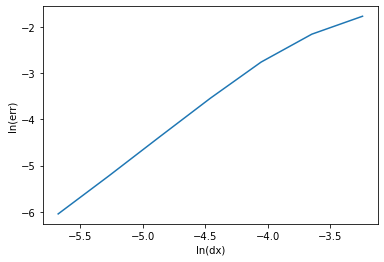

In [4]:
# Данные
t_start = 0
t_end = 1
x_start = 0
x_end = 1

start_func = gaus
g = 1
H = 1
c = math.sqrt(g * H)

dx_set = [1.5**(-i) for i in range(8, 15)]
kurant = 2.0

sqrt_err = []
for dx in dx_set:
    dt = dx * kurant / c
    res = wave_1d(g, H, start_func, dt, dx, t_start, t_end, x_start, x_end)
    vals, x_grid, t_grid = res["result"]["values"], res["result"]["x_grid"], res["result"]["t_grid"]
    h_vals = []
    for i in range(len(vals)):
        h_vals.append(np.copy(vals[i][1]))

    theor_vals = wave_1d_eq_solve(c, func_sim(start_func, x_start, x_end), x_grid, t_grid)
    err = np.array([np.max(h_vals[i] - theor_vals[i]) for i in range(len(t_grid))])
    sqrt_err.append(linalg.norm(err, ord = 2) / math.sqrt(len(t_grid)))

# Графики
plt.xlabel('ln(dx)')
plt.ylabel('ln(err)')
ln_dx_set = [math.log(dx_set[i]) for i in range(len(dx_set))]
ln_sqrt_err = [math.log(sqrt_err[i]) for i in range(len(sqrt_err))]
plt.plot(ln_dx_set, ln_sqrt_err)
plt.show()

Теперь реализуем SBP оператор $D_{1}^{2,4}$ для нулевых условий. 

\begin{cases}
    \frac{\partial u(t)}{\partial t} = - g \cdot D h\\
    \frac{\partial h(t)}{\partial t} = - H_0 \cdot (D u \ + \bar{e_1} u_1 - \bar{e_n} u_n)\\
\end{cases}

$E = H_0(u, u)_H + g(h, h)_H$ (дискретный аналог интегрирования квадрата скорости и квадрата высоты).

Закон сохранения энергии (основываясь на том, что H - диагональна): 

![alt text](1.jpg).

Так как $\sigma = 1 < \frac{1}{H_{11}} = 2.8$ в моем коде, поэтому задача устойчива.

Закон сохранения масс:

![alt text](2.jpg).

Масса сохраняется при тех же условиях, что и энергия

**Вычисления**
Реализована аналогичичая ранней функция wave_1d_SBP с измененной пространственной производной

Пространственный порядок: p = 4 (ошибка считалась в среднем квадратичном).
График подтверждает резальтат

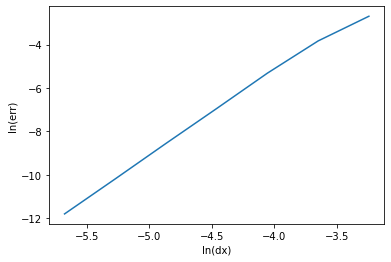

In [12]:
def wave_1d_SBP(g, H_0, func, dt, dx, t_start, t_end, x_start, x_end):
    # калибровка длины шага, чтобы из вмещалось целое число
    N_t = int((t_end - t_start) / dt)
    dt = (t_end - t_start) / N_t
    N_x = int((x_end - x_start) / dx)
    dx = (x_end - x_start) / N_x
    c = math.sqrt(g * H_0)

    # начальный вектор значений функции при x от 0 до 1 при t = 0
    x = [x_start + i * dx for i in range(N_x + 1)]
    t = [t_start + i * dt for i in range(N_t + 1)]
    f_0 = [np.array([0 for i in range(N_x + 1)]), np.array([func(x[i]) for i in range(N_x + 1)])]

    H = np.eye(N_x + 1)
    H[0][0], H[1][1], H[2][2], H[3][3] = (17/48, 59/48, 43/48, 49/48)
    for i in range(4):
        H[N_x - i][N_x - i] = H[i][i]
    Q = np.zeros((N_x + 1, N_x + 1))
    Q[0][0], Q[0][1], Q[0][2], Q[0][3], Q[1][2], Q[1][3], Q[2][3], Q[2][4], Q[3][4], Q[3][5] = (
        -1/2, 59/96, -1/12, -1/32, 59/96, 0.0, 59/96, -1/12, 2/3, -1/12
    )
    for i in range(4):
        for j in range(0, i):
            Q[i][j] = - Q[j][i]
    
    for i in range(4, N_x - 3):
        Q[i][i-2:i+3] = (1/12, -2/3, 0.0, 2/3, -1/12)
    
    for i in range(4):
        for j in range(6):
            Q[N_x - i][N_x - j] = - Q[i][j]
    
    D = np.linalg.inv(H) @ Q
    sigma = 1/H[0][0]
    # вместо правой части производная по координате
    def minus_x_diff(vec, t):
        u = np.copy(vec[0])
        h = np.copy(vec[1])
        e_1 = np.zeros(N_x + 1)
        e_1[0] = 1
        e_n = np.zeros(N_x + 1)
        e_n[N_x] = 1
        return np.array([-g*D@h / dx, H_0*(-D@u - u[0]*e_1*sigma + u[N_x]*e_n*sigma) / dx])

    # МРК 4 для шага по времени
    # вместо правой части в explicit_runge_kutt кидаем производную по координате
    rk_res =  explicit_runge_kutt(N_t, dt, t_start, f_0, minus_x_diff) 
    return {"result": {"values": rk_res, "x_grid": x, "t_grid": t}}

# тот же самый кусок кода для графиклов, только с wave_1d_SPB вместо wave_1d
kurant = 1.0
sqrt_err = []
for dx in dx_set:
    dt = dx * kurant / c
    res = wave_1d_SBP(g, H, start_func, dt, dx, t_start, t_end, x_start, x_end)
    vals, x_grid, t_grid = res["result"]["values"], res["result"]["x_grid"], res["result"]["t_grid"]
    h_vals = []
    for i in range(len(vals)):
        h_vals.append(np.copy(vals[i][1]))

    theor_vals = wave_1d_eq_solve(c, func_sim(start_func, x_start, x_end), x_grid, t_grid)
    err = np.array([np.max(h_vals[i] - theor_vals[i]) for i in range(len(t_grid))])
    sqrt_err.append(linalg.norm(err, ord = 2) / math.sqrt(len(t_grid)))

# Графики
plt.xlabel('ln(dx)')
plt.ylabel('ln(err)')
ln_dx_set = [math.log(dx_set[i]) for i in range(len(dx_set))]
ln_sqrt_err = [math.log(sqrt_err[i]) for i in range(len(sqrt_err))]
plt.plot(ln_dx_set, ln_sqrt_err)
plt.show()


# ***Двумерное уравнение мелкой воды с учетом силы Кориолиса***

\begin{cases}
    \frac{\partial u}{\partial t} = - g \frac{\partial h}{\partial x} + f v\\
    \frac{\partial v}{\partial t} = - g \frac{\partial h}{\partial y} - f u\\
    \frac{\partial h}{\partial t} = - H (\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y})
\end{cases}

Разностсная схема: МРК 4 по времени и метод трапеций по обоем координатам.

1) Устойчивость. 

\begin{equation*}
  \begin{pmatrix}
    u \\
    v \\
    h 
  \end{pmatrix} =
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{v}(t) \\
    \hat{h}(t)
  \end{pmatrix} e^{i(k\alpha + l \beta)}
\end{equation*}

Подставим в разностную схему и получим: 


\begin{cases}
    \frac{\partial \hat{u}(t)}{\partial t} = - g \hat{h}(t) \cdot i\frac{\sin{k}}{dx} + f \hat{v}(t)\\
     \frac{\partial \hat{v}(t)}{\partial t} = - g \hat{h}(t) \cdot i\frac{\sin{l}}{dy} - f \hat{u}(t)\\
    \frac{\partial \hat{h}(t)}{\partial t} = - H \cdot i(\hat{u}(t)\frac{\sin{k}}{dx} + \hat{v}(t)\frac{\sin{l}}{dy}) 
\end{cases}

Или в виде системы:

\begin{equation*}
 \frac{\partial}{\partial t}
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{v}(t) \\
    \hat{h}(t)
  \end{pmatrix} =
  \begin{pmatrix}
  0 & f & - i g\frac{\sin{k}}{dx} \\
  -f & 0 & - i g\frac{\sin{l}}{dy} \\
  - i H \frac{\sin{k}}{dx} &  -i H \frac{\sin{l}}{dy}  & 0
\end{pmatrix}
  \begin{pmatrix}
    \hat{u}(t) \\
    \hat{v}(t) \\
    \hat{h}(t)
  \end{pmatrix}
\end{equation*}

Полином на поиск собственных значений: 

$$P(\lambda) = \lambda(\lambda^2 + gH(\frac{\sin^2 k}{dx^2} + \frac{\sin^2 l}{dy^2}) + f^2)$$

Откуда $\lambda_1 = 0$, $\lambda_{2,3} = \pm c \sqrt{(\frac{\sin^2 k}{dx^2} + \frac{\sin^2 l}{dy^2}) + f^2}$

Самый большой по модулю $\lambda_3$ (с минусом в дискриминанте), и при $\sin{k} = \sin{l} = 1$.

$$dt \cdot c \sqrt{(\frac{\sin^2 k}{dx^2} + \frac{\sin^2 l}{dy^2}) + f^2} < 2.8$$


2) Реализация. См "2_d_wave.py". Параметр Кориолиса установлен таким, чтобы радиус Россби был соизмерим с прямоугольником.